<a href="https://colab.research.google.com/github/sidms24/internship/blob/main/week%205/Strain_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 36.1 MB/s eta 0:00:00


In [3]:
from google.colab import userdata
import os
github_token = userdata.get('GITHUB_TOKEN')

url = 'https://raw.githubusercontent.com/sidms24/internship/main/week%205/cleaned_data.csv'
filename = 'cleaned_data.csv'
os.system(f'wget --header="Authorization: token {github_token}" -O "{filename}" "{url}"')

url = 'https://raw.githubusercontent.com/sidms24/internship/main/week%205/sequences%20(1).fasta'
filename = 'sequences.fasta'
os.system(f'wget --header="Authorization: token {github_token}" -O "{filename}" "{url}"')

url = 'https://raw.githubusercontent.com/sidms24/internship/main/week%205/sequences(all).csv'
filename = 'sequences(all).csv'
os.system(f'wget --header="Authorization: token {github_token}" -O "{filename}" "{url}"')


url = 'https://raw.githubusercontent.com/sidms24/internship/main/week%205/sequences(all).fasta'
filename = 'sequences(all).fasta'
os.system(f'wget --header="Authorization: token {github_token}" -O "{filename}" "{url}"')



0

In [4]:
import pandas as pd
import Bio
from Bio import SeqIO
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
records =[]
for record in SeqIO.parse("sequences.fasta", "fasta"):
    records.append({"Accession": record.id.split('.')[0], "Sequence": str(record.seq)})
df = pd.DataFrame(records)

In [7]:
clean_data = pd.read_csv("cleaned_data.csv", index_col=0)
df = df.merge(clean_data, on='Accession', how='inner')

In [8]:
training_records = []
for record in SeqIO.parse("sequences(all).fasta", "fasta"):
    training_records.append({"Accession": record.id.split('.')[0], "Sequence": str(record.seq)})
df_train = pd.DataFrame(training_records)

In [9]:
train_df = pd.read_csv("sequences(all).csv", index_col=0)
df_train = df_train.merge(train_df, on='Accession', how='inner')
df_train = df_train[["Accession", "Sequence", "Length"]]

In [12]:
for i in range(len(df)):
  if len(df.iloc[i, 2].split(" ")) > 3:
        df.iloc[i, 4]= df.iloc[i, 2].split(" ")[-1].split('/0')[-1].split('(')[-1].strip(')')

In [14]:
def one_hot_encode(seq,max_length = 2366):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], "T": [0, 0, 0, 1]}
    one_hot = [mapping.get(base, [0, 0, 0, 0]) for base in seq]

    # 2. Calculate the amount of padding needed
    padding_needed = max_length - len(one_hot)

    # 3. Create the padding (a list of zero vectors)
    #    Ensure padding_needed is not negative if a sequence is too long.
    if padding_needed > 0:
        padding = [[0, 0, 0, 0]] * padding_needed
        one_hot.extend(padding)

    # Optional: Truncate sequences that are longer than max_length
    elif padding_needed < 0:
        one_hot = one_hot[:max_length]

    return one_hot


In [15]:
df['Sequence_one_hot'] = df['Sequence'].apply(one_hot_encode)
one_hot = pd.get_dummies(df['Segment'], dtype= int)
df['Segment_one_hot'] = one_hot.values.tolist()
df_train["Sequence_one_hot"] = df_train["Sequence"].apply(one_hot_encode)

In [16]:
X= np.array([np.array(seq) for seq in df_train['Sequence_one_hot'].values])

X= np.array([seq.flatten() for seq in X])

X = torch.tensor(X, dtype=torch.float32)
X = X.to(device)

In [17]:
Train_loader = DataLoader(X, batch_size=16, shuffle=False)

In [18]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
     super().__init__()
     self.encoder = nn.Sequential(
         nn.Linear(input_dim, hidden_dim),
         nn.ReLU(),
         nn.Linear(hidden_dim, hidden_dim // 2),
         nn.ReLU(),
         nn.Linear(hidden_dim // 2, hidden_dim // 4),
         nn.ReLU(),
         nn.Linear(hidden_dim // 4, hidden_dim // 8),
         nn.ReLU(),
         nn.Linear(hidden_dim // 8, latent_dim))

  def forward(self, x):
    return self.encoder(x)

class Decoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, output_dim):
     super().__init__()
     self.decoder = nn.Sequential(
         nn.Linear(latent_dim, hidden_dim // 8),
         nn.ReLU(),
         nn.Linear(hidden_dim // 8, hidden_dim // 4),
         nn.ReLU(),
         nn.Linear(hidden_dim // 4, hidden_dim // 2),
         nn.ReLU(),
         nn.Linear(hidden_dim // 2, hidden_dim),
         nn.ReLU(),
         nn.Linear(hidden_dim, output_dim))
  def forward(self, x):
    return self.decoder(x)

In [19]:
encoder = Encoder(input_dim=X.shape[1], hidden_dim=128, latent_dim=2).to(device)
decoder = Decoder(2, 128, X.shape[1]).to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0001)
criterion = nn.MSELoss()
epochs = 100
bar = tqdm(range(epochs))
for epoch in bar:
    epoch_loss = 0.0
    for batch in Train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        encoded = encoder(batch)
        decoded = decoder(encoded)
        loss = criterion(decoded, batch)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
    epoch_loss /= len(Train_loader)
    bar.set_description(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

Epoch [100/100], Loss: 0.0095: 100%|██████████| 100/100 [03:45<00:00,  2.25s/it]


In [20]:
weights = encoder.state_dict()
torch.save(weights, 'encoder_weights.pth')
decoder_weights = decoder.state_dict()
torch.save(decoder_weights, 'decoder_weights.pth')


In [21]:
Xt= np.array([np.array(seq) for seq in df['Sequence_one_hot'].values])

Xt= np.array([seq.flatten() for seq in Xt])

Xt = torch.tensor(Xt, dtype=torch.float32)
Xt = Xt.to(device)


with torch.no_grad():
  latent = encoder(Xt)
latent = latent.cpu().numpy()

df['Latent'] = latent.tolist()

/tmp/ipython-input-23-2728459450.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(unique_genotypes)) # Using viridis colormap
/tmp/ipython-input-23-2728459450.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_segments = cm.get_cmap('tab20', len(unique_segments)) # Using viridis colormap


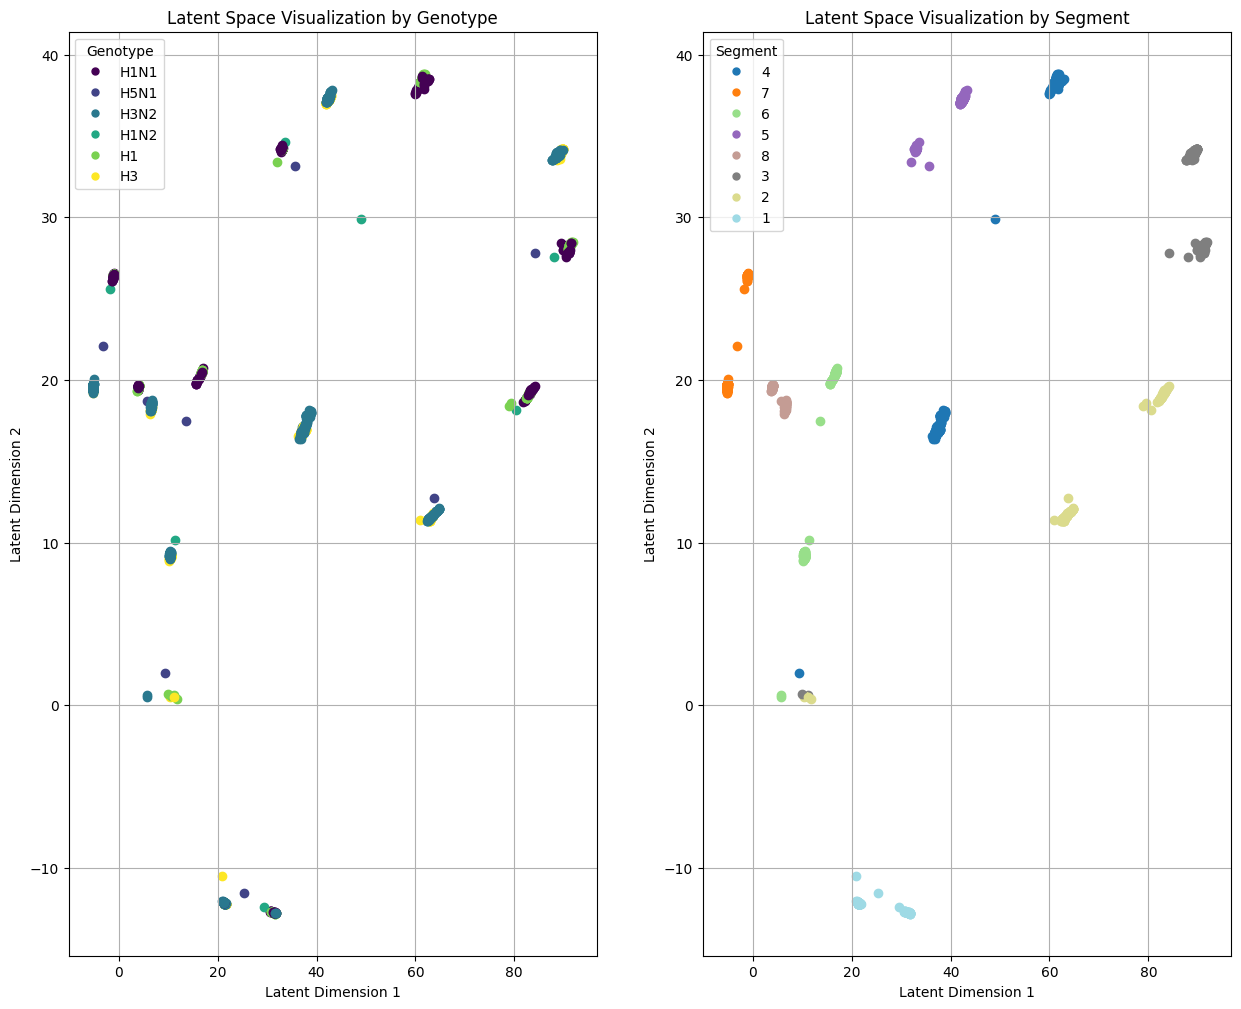

In [23]:
import matplotlib.cm as cm

# Get unique genotypes and assign a color to each
unique_genotypes = df['Genotype'].unique()
colors = cm.get_cmap('viridis', len(unique_genotypes)) # Using viridis colormap
unique_segments = df['Segment'].unique()
colors_segments = cm.get_cmap('tab20', len(unique_segments)) # Using viridis colormap


genotype_color_map = {genotype: colors(i) for i, genotype in enumerate(unique_genotypes)}
segment_color_map = {segment: colors_segments(i) for i, segment in enumerate(unique_segments)}
# Prepare color list for scatter plot based on genotype
point_colors = [genotype_color_map[genotype] for genotype in df['Genotype']]
points_cols = [segment_color_map[segment] for segment in df['Segment']]


fig, ax = plt.subplots(figsize=(15, 12), nrows= 1, ncols = 2)
for i in range(len(df)):
  ax[0].scatter(df['Latent'].iloc[i][0], df['Latent'].iloc[i][1], color=point_colors[i],
              label=df['Genotype'].iloc[i] if i < len(unique_genotypes) else "")
  ax[1].scatter(df['Latent'].iloc[i][0], df['Latent'].iloc[i][1], color=points_cols[i],
              label=df['Segment'].iloc[i] if i < len(unique_segments) else "")

# Create a legend

handles = [plt.Line2D([], [], marker='o', color=genotype_color_map[genotype], linestyle='None', markersize=5, label=genotype) for genotype in unique_genotypes]
ax[0].legend(handles=handles, title="Genotype")
handles = [plt.Line2D([], [], marker='o', color=segment_color_map[segment], linestyle='None', markersize=5, label=segment) for segment in unique_segments]
ax[1].legend(handles=handles, title="Segment")
ax[0].set_xlabel('Latent Dimension 1')
ax[0].set_ylabel('Latent Dimension 2')
ax[1].set_xlabel('Latent Dimension 1')
ax[1].set_ylabel('Latent Dimension 2')
ax[0].set_title('Latent Space Visualization by Genotype')
ax[1].set_title('Latent Space Visualization by Segment')
ax[0].grid(True)
ax[1].grid(True)
plt.show()



In [28]:
cleaned_data = clean_data.merge(df[["Accession", "Latent"]], on='Accession', how='inner')
cleaned_data.to_csv('latents.csv')

In [29]:
cleaned_data

,Accession,Genotype,Segment,Length,Collection_Date,season,Latent
0,PV283060,H1N1,1,2280,2024-12-30,2024/25,"[30.597551345825195, -12.617039680480957]"
1,PV283059,H1N1,2,2274,2024-12-30,2024/25,"[81.76383209228516, 18.627729415893555]"
2,PV283058,H1N1,3,2151,2024-12-30,2024/25,"[90.32715606689453, 28.209314346313477]"
3,PV283057,H1N1,8,838,2024-12-30,2024/25,"[3.9423556327819824, 19.518476486206055]"
4,PV283056,H1N1,5,1497,2024-12-30,2024/25,"[33.13465118408203, 34.237300872802734]"
...,...,...,...,...,...,...,...
1491,MK381745,H3N2,8,838,2018-02-07,2017/18,"[6.5306549072265625, 18.491729736328125]"
1492,MK381678,H3N2,5,1497,2018-02-07,2017/18,"[42.337791442871094, 37.20896530151367]"
1493,MK381610,H3N2,6,1410,2018-02-07,2017/18,"[10.402609825134277, 9.40854549407959]"
1494,MK381542,H3N2,7,982,2018-02-07,2017/18,"[-5.180500507354736, 19.723649978637695]"
